<a href="https://colab.research.google.com/github/JohnRuskinONLINE/GEOL0069-Final-Project-JRO/blob/main/Final_Project_JRO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**I RECOMMEND HAVING READ THE GITHUB README BEFORE EMBARKING ON RUNNING THIS CODE**

##Pre-Processing and Preperation

Prior to extracting any data or committing and clustering, it is neccesary that we:
*   Import the libraries neccesary to the execution of the code
*   Define all of our functions neccesary to the execution of the code, therein:
    - get_access_token
    - query_sentinel2_data
    - extract_correct_product_name
    - process_image_pair
    - coordinates_to_tile
    - download_single_product





In [51]:
import ee
import os
from datetime import datetime, timedelta
from shapely.geometry import Polygon, Point
import numpy as np
import subprocess
import requests
import pandas as pd

# Function to get an access token to the Copernicus Dataspace
def get_access_token(username, password):
    """
    Retrieves access token from Copernicus Dataspace using the provided credentials.

    Parameters:
    username (str): Username for Copernicus Dataspace.
    password (str): Password for Copernicus Dataspace.

    Returns:
    str: Access token for authenticated sessions.
    """
    url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'
    data = {
        'grant_type': 'password',
        'username': username,
        'password': password,
        'client_id': 'cdse-public'
    }
    response = requests.post(url, data=data)
    response.raise_for_status()
    return response.json()['access_token']


# Function to query Sentinel-2 data from Copernicus Data Space
def query_sentinel2_data(sensing_start_date, tile_number, token):
    """
    Queries the Sentinel-2 data from the Copernicus Data Space based on sensing start date, tile number, and access token.

    Parameters:
    sensing_start_date (str): The start date and time for the data sensing in the format 'YYYYMMDDTHHMMSS'.
    tile_number (str): The specific tile number of the Sentinel-2 data to be queried.
    token (str): The access token for authenticating requests to the Copernicus Data Space.

    Returns:
    DataFrame: A DataFrame containing the query results with details about the Sentinel-2 data.

    The function constructs a query URL with specified parameters, sends a request to the Copernicus Data Space,
    and returns the results as a DataFrame. It filters the data based on the tile number and the content start date
    within a certain time window.
    """
    # Convert sensing_start_date to datetime object and format it for the query
    start_time = datetime.strptime(sensing_start_date, '%Y%m%dT%H%M%S')
    end_time = start_time + timedelta(hours=2)  # Adjust the time window as necessary
    start_time_str = start_time.strftime('%Y-%m-%dT%H:%M:%SZ')
    end_time_str = end_time.strftime('%Y-%m-%dT%H:%M:%SZ')

    # Construct the request URL with the contains function for tile number
    url = f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=contains(Name,'{tile_number}') and Collection/Name eq 'SENTINEL-2' and ContentDate/Start gt {start_time_str} and ContentDate/Start lt {end_time_str}"
    headers = {'Authorization': f'Bearer {token}'}

    # Make the API request
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    return pd.DataFrame.from_dict(response.json()['value'])

# Define a function to convert coordinates to the MGRS tile that they lie within
def coordinates_to_tile(lat, lon):
    point = ee.Geometry.Point(lon, lat)
    tile_info = ee.Feature(point).buffer(10).bounds().getInfo()
    tile_id = tile_info['properties']['MGRS_TILE']
    return tile_id

# Function to extract the correct Google Earth Engine file name based on user-defined parameters
def extract_correct_product_name(df, start_time, tile_number):
    """
    Extracts the correct product name and ID from a dataframe based on a specific start time and tile number.

    Parameters:
    df (DataFrame): The dataframe containing product information.
    start_time (str): The start time used to filter the products.
    tile_number (str): The tile number used to filter the products.

    Returns:
    tuple: A tuple containing the first matching product name and ID, or (None, None) if no match is found.
    """
    # Adjusted regex pattern to match the filename format
    pattern = f'MSIL1C.*{start_time}.*_{tile_number}_'
    filtered_products = df[df['Name'].str.contains(pattern, regex=True)]

    # Return the first matching product name, or None if not found
    return filtered_products['Name'].iloc[0] if not filtered_products.empty else None, filtered_products['Id'].iloc[0] if not filtered_products.empty else None

# Function to translate a Google Earth Engine file name to a Copernicus Database file URL
def process_image_pair(s2_ee_image_id, token):
    """
    Processes a pair of Sentinel-2 images by querying the Copernicus Data Space to find the corresponding product name and ID.

    Parameters:
    s2_ee_image_id (str): The Sentinel-2 Earth Engine image ID.
    token (str): The access token for authenticating requests to the Copernicus Data Space.

    Returns:
    tuple: A tuple containing the product name and ID for the corresponding Sentinel-2 image.
    """
    sensing_start_date = s2_ee_image_id.split('_')[0]
    tile_number = s2_ee_image_id.split('_')[2]

    # Query the Copernicus Data Space
    df = query_sentinel2_data(sensing_start_date, tile_number, token)

    # Extract the correct MSIL1C product name
    return extract_correct_product_name(df, sensing_start_date, tile_number)

# Function to construct and download the data present at a Copernicus Database URL
def download_single_product(product_id, file_name, access_token, download_dir="downloaded_products"):
    """
    Download a single product from the Copernicus Data Space.

    :param product_id: The unique identifier for the product.
    :param file_name: The name of the file to be downloaded.
    :param access_token: The access token for authorization.
    :param download_dir: The directory where the product will be saved.
    """
    # Ensure the download directory exists
    os.makedirs(download_dir, exist_ok=True)

    # Construct the download URL
    url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"

    # Set up the session and headers
    headers = {"Authorization": f"Bearer {access_token}"}
    session = requests.Session()
    session.headers.update(headers)

    # Perform the request
    response = session.get(url, headers=headers, stream=True)

    # Check if the request was successful
    if response.status_code == 200:
        # Define the path for the output file
        output_file_path = os.path.join(download_dir, file_name + ".zip")

        # Stream the content to a file
        with open(output_file_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
        print(f"Downloaded: {output_file_path}")
    else:
        print(f"Failed to download product {product_id}. Status Code: {response.status_code}")

##Data Acquisition

Here, we begin by initialising the Earth Engine environment, and then defining our area of interest using latitude and longitude, this instance of point data is then used to return the respective military grid reference tile (henceforth MGR), which will act as the basis for our further study. This section of code utilises an aft defined formula.

In [52]:
import ee

# Authenticate and initialize Earth Engine
ee.Reset()
ee.Authenticate()
ee.Initialize(project='week4fetchdatasdn')

# Example coordinates (latitude and longitude)
lat = 37.7749
lon = -122.4194

# Convert coordinates to MGRS tile
tile_name = coordinates_to_tile(lat, lon)
print("Equivalent Sentinel-2 tile:", tile_name)

Here, we initialise a specific project, this is done within the Earth Engine's interface and should be linked to the google account via which you are executing this notebook. In your case 'week4fetchdatasdn' is the file name to replace.

Then, we define the date range within which to capture the Sentinel-2 image, in this notebook, I ran this block twice, with a data range for 2017 (the first full operational year of Sentinel-2) and 2023, the most recent full operational year.

Then, within these operational years, the images are filtered as to be as least cloudy as possible, an often unavoidable element that plays havoc with unsupervised classification algorithms.

The product of this is a Google Earth Engine filename, corresponding to the MGR and date range defined by the user.

In [53]:
import ee

# Define the date range for filtering Sentinel-2 images
start_date = '2023-01-01'
end_date = '2024-12-31'

# Define the tile identifier you want to filter by
tile = tile_name

# Load Sentinel-2 collection and filter by date range and tile ID
collection = ee.ImageCollection('COPERNICUS/S2') \
    .filterDate(start_date, end_date) \
    .filterMetadata('MGRS_TILE', 'equals', tile)

# Function to calculate cloud coverage
def calculate_cloud_coverage(image):
    cloud_percentage = ee.Image(image).get('CLOUDY_PIXEL_PERCENTAGE')
    return ee.Image(image).set('cloud_percentage', cloud_percentage)

# Map the function over the collection to calculate cloud coverage for each image
collection_with_cloud_coverage = collection.map(calculate_cloud_coverage)

# Sort the collection by cloud coverage in ascending order
sorted_collection = collection_with_cloud_coverage.sort('cloud_percentage')

# Get the ID of the least cloudy image
least_cloudy_image_id = sorted_collection.first().id().getInfo()

print("ID of the least cloudy image:", least_cloudy_image_id)

Creating a Copernicus Space Database account is free, and instrumental to this code. Having done so, the Earth Engine file ID is translated into a download URL for the Space Database, the file at that directory is saved to a defined location as a *.zip file that contains all the satellite data for that tile at the defined time.

In [ ]:
# Username and password for user's Copernicus Space Database (CSD) account
username = 'zcfbsne@ucl.ac.uk'
password = '9XzTbN4!_v_Unqn'

# Using aft described functions to produce an access token with which to access the CSD
token = get_access_token(username, password)
access_token = token
download_dir = '/content/drive/MyDrive/Final_Project'

# Using aft described functions to download the equivilent file from the CSD
gee_filename = least_cloudy_image_id
token = get_access_token(username, password)
file_name, product_id = process_image_pair(gee_filename, token)
download_single_product(product_id, file_name, access_token, download_dir)
print(file_name)

Downloaded: /content/drive/MyDrive/Final_Project/S2A_MSIL1C_20230618T140711_N0509_R110_T21LUG_20230618T191359.SAFE.zip
S2A_MSIL1C_20230618T140711_N0509_R110_T21LUG_20230618T191359.SAFE


Following this, it is neccesary to unzip the file into the same directory it was downloaded.

##Data Processing

Having acquired our data, run twice to produce values for the same MGR at both 2017 and 2023, we process and execute unsupervised GMM clustering upon it. From our unzipped files we extract bands 4, 3, and 2 - red, green, and blue, respectively. We then stack these bands to produce a full-colour image, filter out any invalid data and reshape the array so it is suitable for machine learning. Having done this, we fit a GMM model to the dataset and define two clusters, qualitively: urban and natural. The model we have trained and the results, in array form and visualised, are downloaded to a user defined directory.

In [ ]:
# If it is neccasary to do so, run this code uncommented
#!pip install rasterio;

In [ ]:
import rasterio
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from PIL import Image
from joblib import dump

#Remember to add a '/' at the end of var base_path
base_path = '/content/drive/MyDrive/Final_Project/S2A_MSIL1C_20170609T141051_N0205_R110_T21LUG_20170609T141441.SAFE/S2A_MSIL1C_20170609T141051_N0205_R110_T21LUG_20170609T141441.SAFE/GRANULE/L1C_T21LUG_A010260_20170609T141441/IMG_DATA/' # You need to specify the path
bands_paths = {
    'B4': base_path + 'T21LUG_20170609T141051_B04.jp2',
    'B3': base_path + 'T21LUG_20170609T141051_B03.jp2',
    'B2': base_path + 'T21LUG_20170609T141051_B02.jp2'
}


# Read and stack the band images
band_data = []
for band in ['B4', 'B3', 'B2']:
    with rasterio.open(bands_paths[band]) as src:
        band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
band_stack = np.dstack(band_data)
valid_data_mask = np.all(band_stack > 0, axis=2)

# Reshape for GMM, only including valid data
X = band_stack[valid_data_mask].reshape((-1, 3))

# GMM clustering
gmm = GaussianMixture(n_components=2, random_state=0).fit(X)
labels = gmm.predict(X)

# Create an empty array for the result, filled with a no-data value (e.g., -1)
labels_image = np.full(band_stack.shape[:2], -1, dtype=int)

# Place GMM labels in the locations corresponding to valid data
labels_image[valid_data_mask] = labels

# Save GMM model
dump(gmm, '/content/drive/MyDrive/Final_Project/GMM_model_MG_2017.npy')

# Save labels
np.save('/content/drive/MyDrive/Final_Project/GMM_labels_MG_2017.npy', labels)

# Save labels image
plt.imsave('/content/drive/MyDrive/Final_Project/GMM_Clustering_MG_2017.png', labels_image, cmap='viridis')

In [ ]:
import rasterio
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from PIL import Image
from joblib import dump

#Remember to add a '/' at the end of var base_path
base_path = '/content/drive/MyDrive/Final_Project/S2A_MSIL1C_20230618T140711_N0509_R110_T21LUG_20230618T191359.SAFE/S2A_MSIL1C_20230618T140711_N0509_R110_T21LUG_20230618T191359.SAFE/GRANULE/L1C_T21LUG_A041720_20230618T141337/IMG_DATA/' # You need to specify the path
bands_paths = {
    'B4': base_path + 'T21LUG_20230618T140711_B04.jp2',
    'B3': base_path + 'T21LUG_20230618T140711_B03.jp2',
    'B2': base_path + 'T21LUG_20230618T140711_B02.jp2'
}


# Read and stack the band images
band_data = []
for band in ['B4', 'B3', 'B2']:
    with rasterio.open(bands_paths[band]) as src:
        band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
band_stack = np.dstack(band_data)
valid_data_mask = np.all(band_stack > 0, axis=2)

# Reshape for GMM, only including valid data
X = band_stack[valid_data_mask].reshape((-1, 3))

# GMM clustering
gmm = GaussianMixture(n_components=2, random_state=0).fit(X)
labels = gmm.predict(X)

# Create an empty array for the result, filled with a no-data value (e.g., -1)
labels_image = np.full(band_stack.shape[:2], -1, dtype=int)

# Place GMM labels in the locations corresponding to valid data
labels_image[valid_data_mask] = labels

# Save GMM model
dump(gmm, '/content/drive/MyDrive/Final_Project/GMM_model_MG_2023.npy')

# Save labels
np.save('/content/drive/MyDrive/Final_Project/GMM_labels_MG_2023.npy', labels)

# Save labels image
plt.imsave('/content/drive/MyDrive/Final_Project/GMM_Clustering_MG_2023.png', labels_image, cmap='viridis')

Then, having executed the GMM clustering twice, we load our full-colour images and clustered images for each time-step, and using the below libraries, plot them beside each other to visualise change prior to additional calculations.

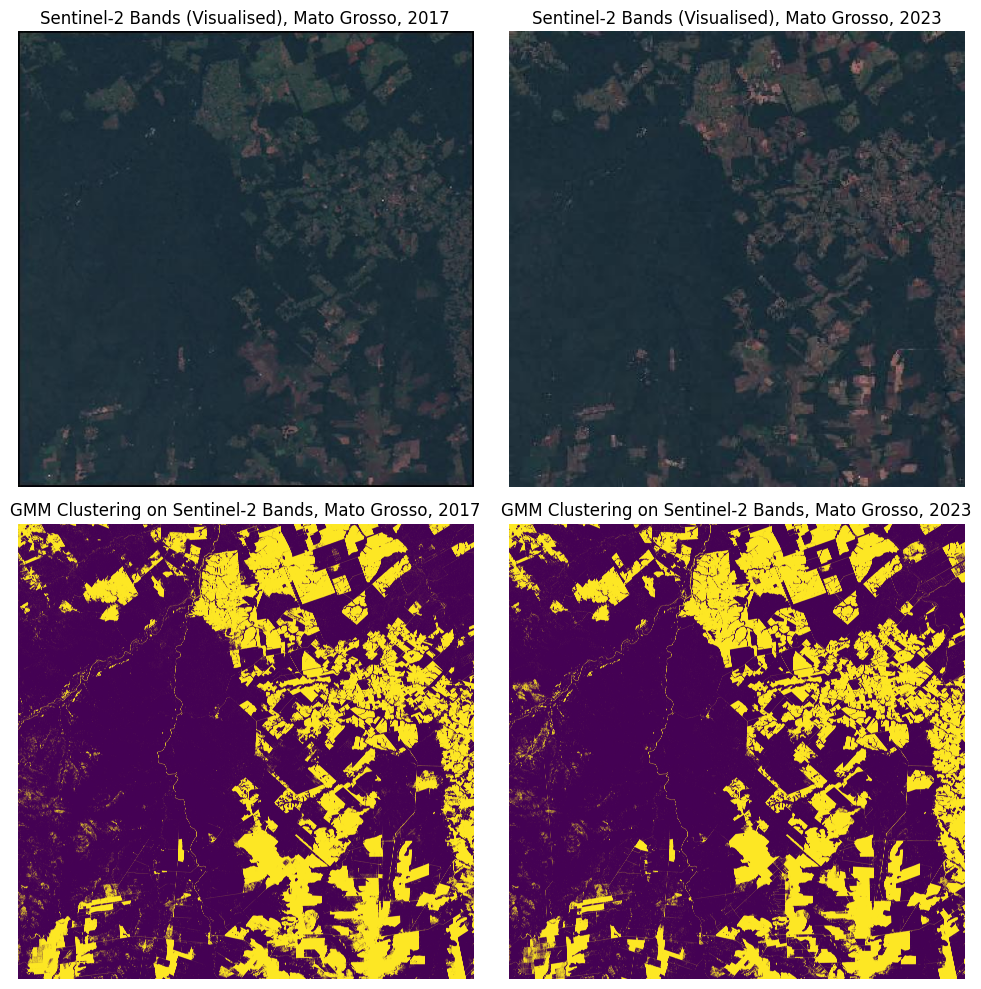

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Paths to your .jpg image files
image_path1 = '/content/drive/MyDrive/Final_Project/S2A_MSIL1C_20170609T141051_N0205_R110_T21LUG_20170609T141441.SAFE/S2A_MSIL1C_20170609T141051_N0205_R110_T21LUG_20170609T141441.SAFE/S2A_MSIL1C_20170609T141051_N0205_R110_T21LUG_20170609T141441-ql.jpg'
image_path2 = '/content/drive/MyDrive/Final_Project/S2A_MSIL1C_20230618T140711_N0509_R110_T21LUG_20230618T191359.SAFE/S2A_MSIL1C_20230618T140711_N0509_R110_T21LUG_20230618T191359.SAFE/S2A_MSIL1C_20230618T140711_N0509_R110_T21LUG_20230618T191359-ql.jpg'
image_path3 = '/content/drive/MyDrive/Final_Project/GMM_Clustering_MG_2017.png'  # Path to your third image
image_path4 = '/content/drive/MyDrive/Final_Project/GMM_Clustering_MG_2023.png'  # Path to your fourth image

# Load the images
img1 = mpimg.imread(image_path1)
img2 = mpimg.imread(image_path2)
img3 = mpimg.imread(image_path3)
img4 = mpimg.imread(image_path4)

# Create a figure and set of axes with four subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Adjust figsize as needed

# Plot the first image on the top-left subplot
axes[0, 0].imshow(img1)
axes[0, 0].axis('off')  # Turn off axis
axes[0, 0].set_title('Sentinel-2 Bands (Visualised), Mato Grosso, 2017')  # Optional: Set title for the first image

# Plot the second image on the top-right subplot
axes[0, 1].imshow(img2)
axes[0, 1].axis('off')  # Turn off axis
axes[0, 1].set_title('Sentinel-2 Bands (Visualised), Mato Grosso, 2023')  # Optional: Set title for the second image

# Plot the third image on the bottom-left subplot
axes[1, 0].imshow(img3)
axes[1, 0].axis('off')  # Turn off axis
axes[1, 0].set_title('GMM Clustering on Sentinel-2 Bands, Mato Grosso, 2017')   # Optional: Set title for the third image

# Plot the fourth image on the bottom-right subplot
axes[1, 1].imshow(img4)
axes[1, 1].axis('off')  # Turn off axis
axes[1, 1].set_title('GMM Clustering on Sentinel-2 Bands, Mato Grosso, 2023')  # Optional: Set title for the fourth image

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [ ]:
import numpy as np

# Loading our results again, allowing for greater ease of access
labels_2017 = np.load('/content/drive/MyDrive/Final_Project/GMM_labels_MG_2017.npy')
labels_2023 = np.load('/content/drive/MyDrive/Final_Project/GMM_labels_MG_2023.npy')

Here, we use the variation in cluster quantities to provide a crude initial estimation of the change using a commonly recognised metric of deforestation: football pitches. Statistic like these are often useful when conversing with stakeholders.

In [ ]:
# Assuming 'labels' is the variable produced by your GMM clustering
label_counts_2017 = np.bincount(labels_2017)
label_counts_2023 = np.bincount(labels_2023)

ratio_2017 = (label_counts_2017[1]/ label_counts_2017.sum()) * 100
ratio_2023 = (label_counts_2023[1]/ label_counts_2023.sum()) * 100
change = ratio_2023 - ratio_2017

deforestation_change = round(((band_stack.shape[0] * band_stack.shape[1]) * (change / 100)), 3)
as_football_pitches = round((deforestation_change / 4050), 0)

# Where 1 pixel equal 100m^2, at a 10m dimension per pixel
print("In the time between 2017 and 2023, in the grid-area described by Sentinel-2, there has been deforestation equal to: " + str(deforestation_change) + " metres squared.")
print("That's equivalent to " + str(as_football_pitches) + " 11-a-side football pitches.")

Then, we re-import our GMM results as binary masks, and create a new mask where any change has occured between the two.

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the two binary images
image1 = cv2.imread('/content/drive/MyDrive/Final_Project/GMM_Clustering_MG_2017.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('/content/drive/MyDrive/Final_Project/GMM_Clustering_MG_2023.png', cv2.IMREAD_GRAYSCALE)

# Compare pixel values to detect changes
changed_pixels = cv2.absdiff(image1, image2)
changed_pixels[changed_pixels != 0] = 255  # Set changed pixels to white

This mask is then passed through a smoothing filter to reduce the presence of noise, or erroneous values in the mask such as minor cloudbanks.

In [ ]:
# Adjust kernel size as needed
blurred_image = cv2.GaussianBlur(changed_pixels, (9, 9), 0)

The mask is then thresholded to remove where the smoothing has softened the noise, this is essentially a high-pass filter.

In [ ]:
# Threshold the blurred image to extract only white values
_, thresholded_image = cv2.threshold(blurred_image, 245, 255, cv2.THRESH_BINARY)

The thresholded mask is then plotted alongside the mask indicating where change has occured, allowing the visualisation of the efficiency of the above code.

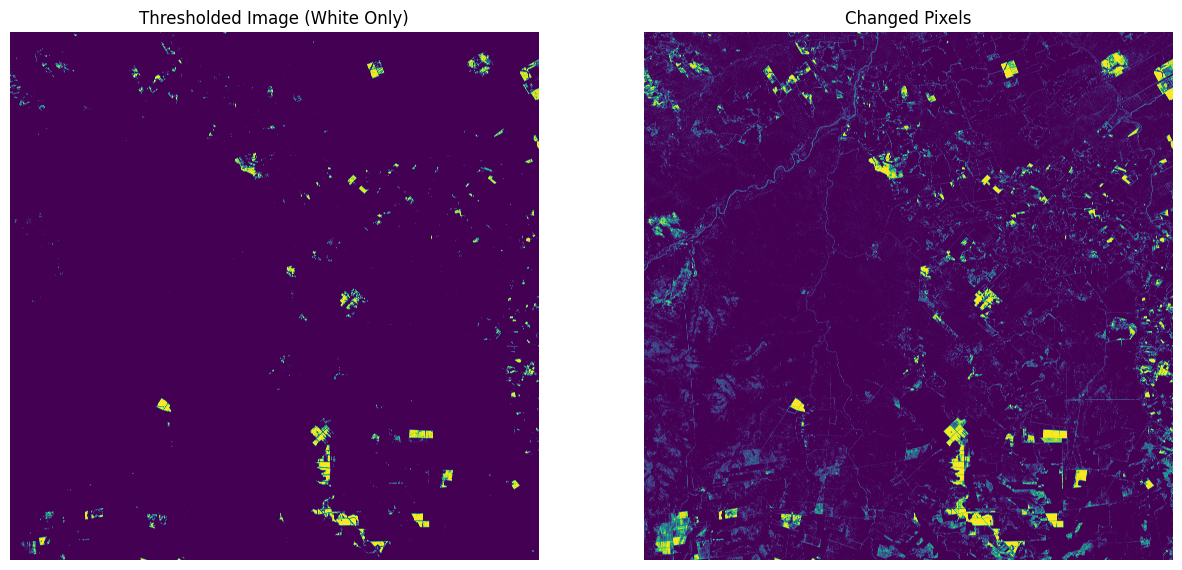

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plot both images side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 15))  # Create a grid of 1 row and 2 columns

# Plot the thresholded image
axes[0].imshow(thresholded_image)
axes[0].set_title('Thresholded Image (White Only)')
axes[0].axis('off')

# Plot the changed_pixels image
axes[1].imshow(changed_pixels)
axes[1].set_title('Changed Pixels')
axes[1].axis('off')

plt.show()

Above, we can see how the filtering has removed ghost structures, and permenant structures such as rivers and roads, which are largely irrelevant to the ensuing calculations

The features identified are then filtered based on area, with each pixel having an area of 100m^2, any feature smaller than 5km^2 is filtered out, though this is easily adjustable with the var min_area_threshold. The result of this filtering is then plotted.

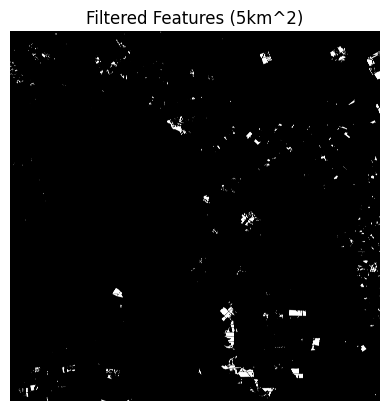

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Find contours
contours, _ = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours based on area
min_area_threshold = 50
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) >= min_area_threshold]

# Create a blank image for visualization
result_image = np.zeros_like(image1)

# Draw filtered contours on the result image
cv2.drawContours(result_image, filtered_contours, -1, (255, 255, 255), thickness=cv2.FILLED)

# Plot the result
plt.imshow(result_image, cmap='gray')
plt.title('Filtered Features (5km^2)')
plt.axis('off')
plt.show()

# Save the result_image as PNG using Matplotlib
plt.imsave('/content/drive/MyDrive/Final_Project/result_image.png', result_image, cmap='gray')

Using centroids and moments, the centre of each of these features is discerned and translated into a coordinate point and appended to the large list var coord, the results of which are printed below.

In [ ]:
!pip install utm

In [ ]:
!pip install mgrs

In [ ]:
!pip install rasterio

In [ ]:
import cv2
import numpy as np
import rasterio
import mgrs

# Get pixel coordinates of the centre of each feature
centre_coordinates = []
for contour in filtered_contours:
    # Calculate centroid using moments
    M = cv2.moments(contour)
    centroid_x = int(M['m10'] / M['m00'])
    centroid_y = int(M['m01'] / M['m00'])
    centre_coordinates.append((centroid_x, centroid_y))

# Print the pixel coordinates of the centre of each feature
print(centre_coordinates)

(3509.5, 10965.5)
(2756.5, 10964.5)
(3595.5, 10928.5)
(1067.5, 10913.5)
(7654.5, 10900.5)
(7646.5, 10886.5)
(1108.5, 10925.5)
(7619.5, 10869.5)
(1120.5, 10878.5)
(7479.5, 10830.5)
(7415.5, 10821.5)
(7620.5, 10818.5)
(7525.5, 10818.5)
(471.5, 10824.5)
(451.5, 10810.5)
(415.5, 10815.5)
(10853.5, 10793.5)
(7563.5, 10803.5)
(7628.5, 10762.5)
(7628.5, 10744.5)
(411.5, 10745.5)
(469.5, 10738.5)
(511.5, 10796.5)
(309.5, 10721.5)
(7274.5, 10716.5)
(7628.5, 10722.5)
(311.5, 10708.5)
(7592.5, 10705.5)
(601.5, 10704.5)
(7709.5, 10758.5)
(368.5, 10690.5)
(1230.5, 10676.5)
(467.5, 10674.5)
(306.5, 10675.5)
(7214.5, 10689.5)
(7359.5, 10676.5)
(370.5, 10659.5)
(7842.5, 10649.5)
(240.5, 10644.5)
(409.5, 10666.5)
(7339.5, 10638.5)
(274.5, 10660.5)
(7892.5, 10638.5)
(269.5, 10609.5)
(366.5, 10625.5)
(406.5, 10610.5)
(7404.5, 10599.5)
(7359.5, 10609.5)
(7163.5, 10645.5)
(7638.5, 10637.5)
(503.5, 10653.5)
(7873.5, 10624.5)
(7801.5, 10619.5)
(7140.5, 10583.5)
(7426.5, 10578.5)
(7368.5, 10567.5)
(798.5, 106

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


These coordinates, once acquired, can be utilised to assist the appropriate forces in discerning as to where and if illegal logging is occuring in areas of the Amazon. Congratulations!